In [1]:
class Config:
    def __init__(self):
        pass

def set_config(config_dict):
    config = Config()
    config.__dict__ = config_dict
    return config

from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn, optim
from jcopdl.callback import Callback
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

columns_train = ['tavg', 'rh_avg', 'rr', 'ff_avg']

config = set_config({
    "input_size": columns_train.__len__(),
    "seq_len": 90,
    "batch_size": 256,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0.1,
    "bidirectional": True,
    "learning_rate": 0.01,
    "max_epochs": 30,
    "time_col": 'tanggal',
    "prediction_col": columns_train[2],
    'much_day_predict': 30,
    'validation_split': 0.1,
})

usecols = [config.time_col] + columns_train

In [2]:
def data4pred(model, dataset, dataloader, device):
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)

            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks, targets, 'b-', label="data")
    plt.plot(dataset.target_ticks, preds, 'r-', label="pred")
    plt.legend()


def pred4pred(model, dataset, dataloader, device, n_prior=500, n_forecast=200):
    preds, targets = [], []
    hidden = None
    end = n_prior + n_forecast
    with torch.no_grad():
        model.eval()
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]

            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)

            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior],
             targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end],
             targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior],
                color='k', linestyle="--", linewidth=1)
    plt.legend()
    
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [3]:
dataset_train = pd.read_csv('../Assets/Data/1985-2021.csv', usecols=usecols, parse_dates=[config.time_col], index_col=config.time_col).replace(to_replace=[8888, 9999, 2555], value=np.nan)

# datelist_train = list(dataset_train[config.time_col])
# datelist_train = [datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

dataset_train.interpolate(inplace=True)

scaller = MinMaxScaler()
dataset_train[columns_train] = scaller.fit_transform(dataset_train[columns_train])

In [4]:
ts_train, ts_test = train_test_split(dataset_train, test_size=config.validation_split, shuffle=False)

train_set = TimeSeriesDataset(ts_train, config.prediction_col, config.seq_len)
trainloader = DataLoader(train_set, batch_size=config.batch_size)

test_set = TimeSeriesDataset(ts_test, config.prediction_col, config.seq_len)
testloader = DataLoader(test_set, batch_size=config.batch_size)

(N, S, F): (130, 90, 4)
Note: last 24 data excluded

(N, S, F): (14, 90, 4)
Note: last 42 data excluded



In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout, bidirectional):
        super().__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, bidirectional=bidirectional)
        
        if bidirectional:
            hidden_size = 2*hidden_size
            
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):        
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [6]:
model = LSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout, config.bidirectional).to(device)
criterion = RMSELoss()
optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
callback = Callback(model, config, outdir=f'model/jkse/')

In [7]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    return cost / len(dataset)

Test: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch     1
Train_cost  = 0.0791 | Test_cost  = 0.4443 | 


Test: 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]



Epoch     2
Train_cost  = 0.5083 | Test_cost  = 0.1455 | 


Test: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]



Epoch     3
Train_cost  = 0.1455 | Test_cost  = 0.0717 | 


Test: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



Epoch     4
Train_cost  = 0.0876 | Test_cost  = 0.0850 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0717


Test: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]



Epoch     5
Train_cost  = 0.1026 | Test_cost  = 0.0722 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0717


Test: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]



Epoch     6
Train_cost  = 0.0847 | Test_cost  = 0.0686 | 


Test: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



Epoch     7
Train_cost  = 0.0757 | Test_cost  = 0.0792 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0686


Test: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]



Epoch     8
Train_cost  = 0.0835 | Test_cost  = 0.0801 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0686


Test: 100%|██████████| 1/1 [00:00<00:00, 13.52it/s]



Epoch     9
Train_cost  = 0.0839 | Test_cost  = 0.0729 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0686


Test: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s]



Epoch    10
Train_cost  = 0.0779 | Test_cost  = 0.0679 | 


Test: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]



Epoch    11
Train_cost  = 0.0758 | Test_cost  = 0.0679 | 


Test: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



Epoch    12
Train_cost  = 0.0784 | Test_cost  = 0.0692 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0679


Test: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]



Epoch    13
Train_cost  = 0.0810 | Test_cost  = 0.0692 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0679


Test: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]



Epoch    14
Train_cost  = 0.0809 | Test_cost  = 0.0681 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0679


Test: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s]



Epoch    15
Train_cost  = 0.0787 | Test_cost  = 0.0674 | 


Test: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]



Epoch    16
Train_cost  = 0.0765 | Test_cost  = 0.0684 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0674


Test: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]



Epoch    17
Train_cost  = 0.0757 | Test_cost  = 0.0706 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0674


Test: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]



Epoch    18
Train_cost  = 0.0764 | Test_cost  = 0.0725 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0674


Test: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]



Epoch    19
Train_cost  = 0.0775 | Test_cost  = 0.0729 | 
==> EarlyStop patience =  4 | Best test_cost: 0.0674


Test: 100%|██████████| 1/1 [00:00<00:00, 13.52it/s]



Epoch    20
Train_cost  = 0.0778 | Test_cost  = 0.0717 | 


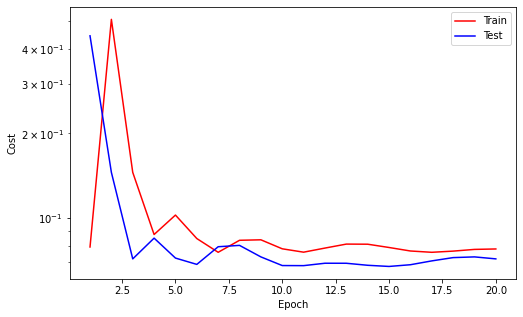

==> EarlyStop patience =  5 | Best test_cost: 0.0674
==> Execute Early Stopping at epoch: 20 | Best test_cost: 0.0674
==> Best model is saved at model/jkse/


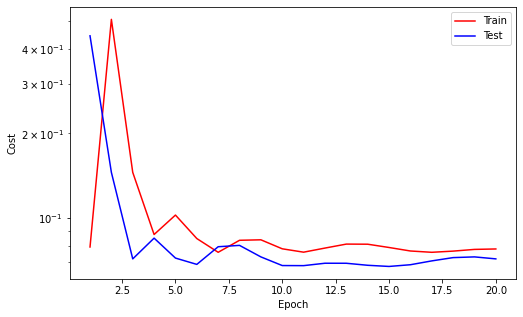

In [8]:
for epoch in range(0, config.max_epochs):
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

In [9]:
train_forecast_set = TimeSeriesDataset(ts_train, config.prediction_col, 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, config.prediction_col, 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (11724, 1, 4)
Note: last 0 data excluded

(N, S, F): (1302, 1, 4)
Note: last 0 data excluded



Text(0.5, 1.0, 'Train')

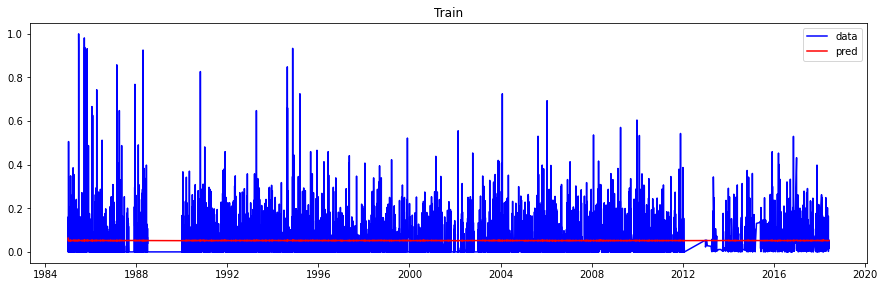

In [13]:
plt.figure(figsize=(15, 15))
plt.subplot(311)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

Text(0.5, 1.0, 'Test')

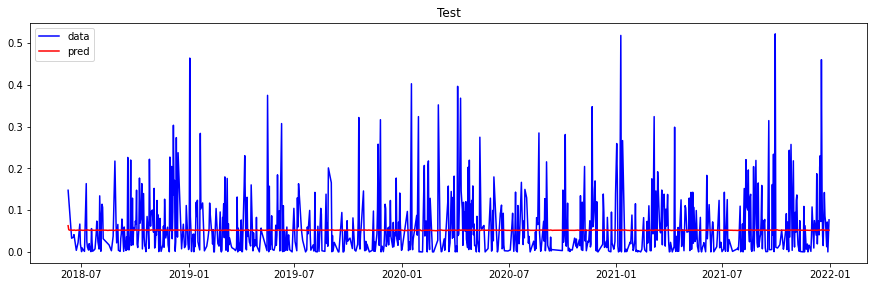

In [14]:
plt.figure(figsize=(15, 15))
plt.subplot(312)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'Predict')

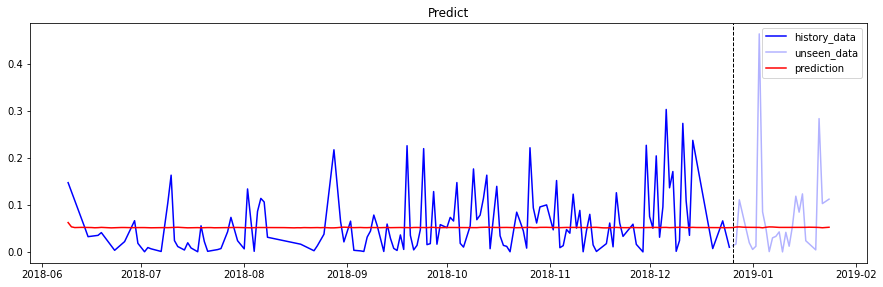

In [18]:
plt.figure(figsize=(15, 15))
plt.subplot(313)
pred4pred(model, test_forecast_set, testforecastloader, device, n_prior=200, n_forecast=config.much_day_predict)
plt.title("Predict")